In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.layers import trunc_normal_,to_2tuple, DropPath

In [ ]:
# @title
#이미지 쪼개기
#(B, H, W, C) -> (B*nW, Ws, Ws, C)
def window_partition(x,window_size):
  B,H,W,C = x.shape
  x=x.view(B,H//window_size,window_size,W//window_size,window_size,C)
  windows=x.permute(0,1,3,2,4,5).contiguous().view(-1,window_size,window_size,C)
  return windows

#이미지 합치기
#(B*nW, Ws, Ws, C) -> (B, H, W, C)
def window_reverse(windows,window_size,H,W):
  B = int(windows.shape[0] / (H * W / window_size / window_size))
  x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
  x = x.permute(0,1,3,2,4,5).contiguous().view(B, H, W, -1)
  return x

이미지->토큰으로 변형

B,3,1024,1024->B,96,256,256

In [ ]:
# @title
class PatchEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96,norm_layer=None):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size) #이미지 분할
        self.norm = norm_layer #프로젝트상 필요 없어서 제거

    def forward(self, x):
        # 이미지 높이, 너비
        _, _, H, W = x.size()
        #패치 크기로 나누어떨어지지 않으면 오른쪽이나 아래 0 채움
        if W % self.patch_size != 0:
            x = F.pad(x, (0, self.patch_size - W % self.patch_size))
        if H % self.patch_size != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size - H % self.patch_size))
        x = self.proj(x)
        return x

해상도를 절반 (H/2,W/2)로 줄이고

피처를 2배(2C)로 늘림.

In [ ]:
# @title
class PatchMerging(nn.Module):

  def __init__(self,dim,norm_layer=nn.LayerNorm):
    super().__init__()
    self.dim = dim
    self.reduction = nn.Linear(4*dim,2*dim,bias=False)
    self.norm = norm_layer(4*dim)

  def forward(self,x,H,W):
    B,L,C=x.shape
    assert L==H*W, "Swin PatchMerging클래스 HW오류" #오류확인
    x=x.view(B,H,W,C)
    pad_input=(H%2==1)or(W%2==1)
    if pad_input:
      x=F.pad(x,(0,0,0,W%2,0,H%2)) # 홀수 픽셀일때 한픽셀씩 채움


    # ::2는 stride=2로 샘플링
    x0 = x[:, 0::2, 0::2, :]  # 좌상단
    x1 = x[:, 1::2, 0::2, :]  # 좌하단
    x2 = x[:, 0::2, 1::2, :]  # 우상단
    x3 = x[:, 1::2, 1::2, :]  # 우하단
    x = torch.cat([x0, x1, x2, x3], -1)  # 텐서 연결
    x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

    x = self.norm(x) #정규화 0~1
    x = self.reduction(x) #채널 반으로 압축

    return x

Multilayer perceptron

FFN(Feed-Forward Network)

2개층 레이어로 구성

In [ ]:
# @title
class Mlp(nn.Module):

    def __init__(
        self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x) #첫번째 레이어
        x = self.act(x) #활성화 함수
        x = self.drop(x) #과적합 방지
        x = self.fc2(x) #두번째 레이어
        x = self.drop(x) #과적합 방지
        return x

윈도우 안에서 작도하는 멀티헤스 셀프어텐션 모듈

관계와 거리 포착

In [ ]:
# @title
class WindowAttention(nn.Module):

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )  # 2*Wh-1 * 2*Ww-1, nH

        #윈도우 내 임의의 위치 두 쌍의 상대좌표를 인덱스 하나로 매핑
        #윈도우 내 xy그리드 생성
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        #(2, Wh, Ww) → (2, Wh*Ww)로 평탄화
        coords_flatten = torch.flatten(coords, 1)
        #상대좌표 구하기
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        #0부터 시작하는 양수 인덱스로 쉬프트
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        #이차원을 일차원으로 변환
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        #더하면 임의의 위치 두 쌍의 고유한 인덱스 값이 나옴
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02) #절단 정규분포로 초기
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        #쿼리, 키, 벨류 분리
        B_, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B_, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4) #(3,B_,H,N,Dh)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale  #루트씌워 소프트맥스 수치 안정화
        attn = q @ k.transpose(-2, -1)  #유사도 계산

        #상대위치 바이어스 더하기
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1
        )
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        #윈도우 밖 넘어서지 않도록
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C) #핵심 attention@Value
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


block

멀티헤드 셀프어텐션 모듈+FFN

윈도우 안에서만 놀지 않게 쉬프팅하여 정보 교환

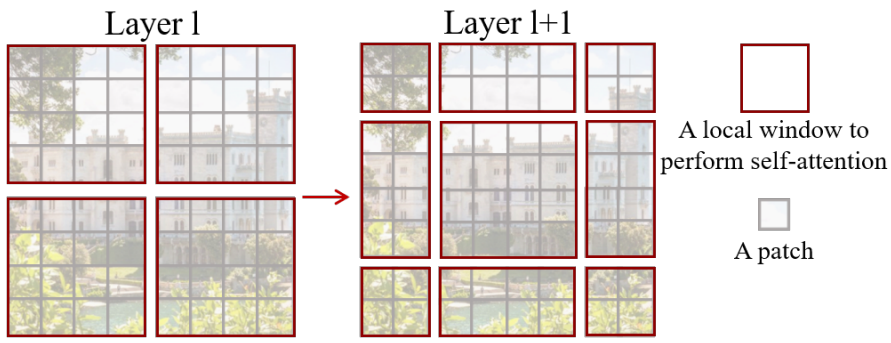

In [ ]:
# @title
class SwinTransformerBlock(nn.Module):

    def __init__(
        self,
        dim,
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop
        )

        self.H = None
        self.W = None

    def forward(self, x, mask_matrix):

        B, L, C = x.shape
        H, W = self.H, self.W
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        #윈도우 크기 배수 맞추기
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        #Shifted window
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        #윈도우 분할
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows, mask=attn_mask)

        #윈도우 병합
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)

        # reverse shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x) #windowattention
        x = x + self.drop_path(self.mlp(self.norm2(x))) #MLP

        return x

Stage : BasicLayer

SwinTransformerBlock을 depth개 쌓은 한 Stage

W-MSA/SW-MSA를 번갈아 포함

In [ ]:
# @title
class BasicLayer(nn.Module):

    def __init__(
        self,
        dim,
        depth,
        num_heads,
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # depth개의 block 리스트
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=0 if (i % 2 == 0) else window_size // 2, # 윈도우 쉬프트
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )

        # PatchMerging
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, H, W):

        #SW-MSA용. window_size의 배수가 되도록 조정
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        w_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        #다른 윈도우면 softmax 0 나오도록 float(-100.0)
        mask_windows = window_partition(img_mask, self.window_size)
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        #블럭 실행
        for blk in self.blocks:
            blk.H, blk.W = H, W
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask) #메모리절약
            else:
                x = blk(x, attn_mask)
        if self.downsample is not None:  # PatchMerging
            x_down = self.downsample(x, H, W)
            Wh, Ww = (H + 1) // 2, (W + 1) // 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W


SwinTransformer

In [ ]:
# @title
class SwinTransformer(nn.Module):
    def __init__(
        self,
        pretrain_img_size=224,
        patch_size=4,
        in_chans=3,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        use_checkpoint=False,
    ):
        super().__init__()

        self.pretrain_img_size = pretrain_img_size
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.out_indices = out_indices
        self.frozen_stages = frozen_stages

        #PatchEmbed #이미지를 토큰으로 변형
        self.patch_embed = PatchEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )

        # absolute position embedding
        if self.ape:
            pretrain_img_size = to_2tuple(pretrain_img_size)
            patch_size = to_2tuple(patch_size)
            patches_resolution = [
                pretrain_img_size[0] // patch_size[0],
                pretrain_img_size[1] // patch_size[1],
            ]

            self.absolute_pos_embed = nn.Parameter(
                torch.zeros(1, embed_dim, patches_resolution[0], patches_resolution[1])
            )
            trunc_normal_(self.absolute_pos_embed, std=0.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth # 과적합 방지용. 일부 블록 확률적으로 건너뜀
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        # Stage쌓기
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)

        #feature 차원 계산
        num_features = [int(embed_dim * 2 ** i) for i in range(self.num_layers)]
        self.num_features = num_features

        #Stage 이름 붙이기
        for i_layer in out_indices:
            layer = norm_layer(num_features[i_layer])
            layer_name = f"norm{i_layer}"
            self.add_module(layer_name, layer)

        self._freeze_stages()

    #지정된 스테이지까지 학습 멈춤
    def _freeze_stages(self):
        if self.frozen_stages >= 0:
            self.patch_embed.eval()
            for param in self.patch_embed.parameters():
                param.requires_grad = False

        if self.frozen_stages >= 1 and self.ape:
            self.absolute_pos_embed.requires_grad = False

        if self.frozen_stages >= 2:
            self.pos_drop.eval()
            for i in range(0, self.frozen_stages - 1):
                m = self.layers[i]
                m.eval()
                for param in m.parameters():
                    param.requires_grad = False

    #가중치 초기화. 사전학습 가중치 있으면 불러오기
    def init_weights(self, pretrained=None):
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=0.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def forward(self, x):

        #PatchEmbed
        x = self.patch_embed(x)

        #이미지 공간 구조
        Wh, Ww = x.size(2), x.size(3)
        if self.ape:
            # interpolate the position embedding to the corresponding size
            absolute_pos_embed = F.interpolate(
                self.absolute_pos_embed, size=(Wh, Ww), mode="bicubic"
            )
            x = (x + absolute_pos_embed).flatten(2).transpose(1, 2)  # B Wh*Ww C
        else:
            x = x.flatten(2).transpose(1, 2)
        x = self.pos_drop(x)

        #Stage 반복
        outs = {}
        for i in range(self.num_layers):
            layer = self.layers[i]
            x_out, H, W, x, Wh, Ww = layer(x, Wh, Ww)

            if i in self.out_indices:
                norm_layer = getattr(self, f"norm{i}")
                x_out = norm_layer(x_out)

                out = x_out.view(-1, H, W, self.num_features[i]).permute(0, 3, 1, 2).contiguous()
                outs["res{}".format(i + 2)] = out

        return outs

    #freeze_stages를 위해 재정의
    def train(self, mode=True):
        super(SwinTransformer, self).train(mode)
        self._freeze_stages()


다른 파트와 연결해주는 브릿지 클래스

In [ ]:
from typing import Optional
class ShapeSpec:
  def __init__(self, channels=None, height=None, width=None, stride=None):
      self.channels = channels
      self.height = height
      self.width = width
      self.stride = stride

In [ ]:
# @title

class D2SwinTransformer(SwinTransformer):
    def __init__(self, cfg, input_shape):

        pretrain_img_size = 224
        patch_size = 4
        in_chans = 3
        embed_dim = 96
        depths = [2, 2, 6, 2]
        num_heads = [3, 6, 12, 24]
        window_size = 7
        mlp_ratio = 4.0
        qkv_bias = True
        qk_scale = None
        drop_rate = 0.0
        attn_drop_rate = 0.0
        drop_path_rate = 0.3
        norm_layer = nn.LayerNorm
        ape = False
        patch_norm = True
        use_checkpoint = False

        super().__init__(
            pretrain_img_size,
            patch_size,
            in_chans,
            embed_dim,
            depths,
            num_heads,
            window_size,
            mlp_ratio,
            qkv_bias,
            qk_scale,
            drop_rate,
            attn_drop_rate,
            drop_path_rate,
            norm_layer,
            ape,
            patch_norm,
            use_checkpoint=use_checkpoint,
        )

        self._out_features = cfg.MODEL.SWIN.OUT_FEATURES

        self._out_feature_strides = {
            "res2": 4,
            "res3": 8,
            "res4": 16,
            "res5": 32,
        }
        self._out_feature_channels = {
            "res2": self.num_features[0],
            "res3": self.num_features[1],
            "res4": self.num_features[2],
            "res5": self.num_features[3],
        }

    def forward(self, x):

        assert (
            x.dim() == 4
        ), f"입력텐서가 (N, C, H, W).가 아닌 {x.shape}"
        outputs = {}
        y = super().forward(x)
        for k in y.keys():
            if k in self._out_features:
                outputs[k] = y[k]
        return outputs

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

    @property
    def size_divisibility(self):
        return 32

스모크 테스트 코드

In [ ]:

# ===== Minimal SMOKE for D2SwinTransformer (no ShapeSpec re-def) =====
import torch, types

def _make_cfg(out_features=("res2","res3","res4","res5")):
    cfg = types.SimpleNamespace()
    cfg.MODEL = types.SimpleNamespace()
    cfg.MODEL.SWIN = types.SimpleNamespace()
    cfg.MODEL.SWIN.OUT_FEATURES = list(out_features)
    return cfg

def _build_model(cfg):
    # 시그니처가 (cfg, ShapeSpec) 인지, (cfg, {"image": ShapeSpec}) 인지 모를 때 안전하게 시도
    try:
        m = D2SwinTransformer(cfg, ShapeSpec(channels=3, height=256, width=256))
    except Exception:
        m = D2SwinTransformer(cfg, {"image": ShapeSpec(channels=3, height=256, width=256)})
    return m

def _print_feats(tag, feats):
    print(tag)
    for k, v in feats.items():
        print(f" - {k:>6}: {tuple(v.shape)}")

def run_smoke():
    print("🚀 Running D2SwinTransformer smoke test (minimal)...")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    cfg = _make_cfg()
    model = _build_model(cfg).to(device)

    # size_divisibility 있으면 출력
    if hasattr(model, "size_divisibility"):
        print("size_divisibility:", model.size_divisibility)

    # 1) 256×256
    x = torch.randn(2, 3, 256, 256, device=device)
    with torch.no_grad():
        feats = model(x)
    assert isinstance(feats, dict), "forward는 dict를 반환해야 합니다."
    _print_feats("📊 256x256 출력:", feats)

    # 2) 임의 크기(패딩/stride 경로 확인)
    x2 = torch.randn(1, 3, 513, 777, device=device)
    with torch.no_grad():
        feats2 = model(x2)
    _print_feats("📊 513x777 출력:", feats2)

    # 3) output_shape() 있으면 간단 검증
    if hasattr(model, "output_shape"):
        try:
            oshp = model.output_shape()
            print("\n🔎 output_shape():")
            for n, spec in oshp.items():
                print(f" - {n:>6}: channels={spec.channels}, stride={spec.stride}")
        except Exception as e:
            print("⚠️ output_shape() 예외:", e)

    print("\n🎉 Minimal smoke PASSED")

if __name__ == "__main__":
    run_smoke()
# ===== /SMOKE =====


🚀 Running D2SwinTransformer smoke test (minimal)...


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


size_divisibility: 32
📊 256x256 출력:
 -   res2: (2, 96, 64, 64)
 -   res3: (2, 192, 32, 32)
 -   res4: (2, 384, 16, 16)
 -   res5: (2, 768, 8, 8)
📊 513x777 출력:
 -   res2: (1, 96, 129, 195)
 -   res3: (1, 192, 65, 98)
 -   res4: (1, 384, 33, 49)
 -   res5: (1, 768, 17, 25)

🔎 output_shape():
 -   res2: channels=96, stride=4
 -   res3: channels=192, stride=8
 -   res4: channels=384, stride=16
 -   res5: channels=768, stride=32

🎉 Minimal smoke PASSED
